# Latent Variable Tutorial

Are you building a Bayesian Network and facing one of the two situations below?

1. You wish to include a very important variable in your model but the amount of high quality data you have about it is extremely low?
2. Or you wish to include a variable for which you have no data at all, but have significant quantitative knowledge about the dependencies of this variable and the rest of the model?

In this tutorial, we show step by step how to add such a variable to your model. Here we shall focus on the interpretability aspect, i.e., we wish to learn condition probability distribution (CPD) parameters that actually represent the latent variable (LV) that we wish to include. This is an overall problem in Latent Variable Model (LVM) and we establish mechanisms to tackle this problem.


## Why add a latent variable?

Several reasons may motivate us to try to include a latent variable, for example:

- **Obtaining true causality** - 
    We know from expert knowledge that adding an LV may create a confounding effect on the existing variables.
    For example, comparing the two structures below, adding an LV $Z$ may better capture the causal relationship between variables $a$ and $b$.
    
| False causality when the LV is not present  | Causality identified when the LV is present  |
| ------------------------------------------- | -------------------------------------------- |
| ![](supporting_files/simple.jpg)            | ![](supporting_files/simple_confounding.jpg) |
    
- **Improving performance** -
    Including an LV changes the Bayesian network (BN) structure and can improve performance. Depending on how the LV is included, this may reduce the number of parameters and avoid overfitting (as in the example below) or increase the number of parameters and make the model more complex.

| Complex network structure without the LV | Simpler structure when the LV is included     |
| ---------------------------------------- | --------------------------------------------- |
| ![](supporting_files/parent_child.jpg)   | ![](supporting_files/parent_latent_child.jpg) |


## Summary of steps

In this tutorial, we will manually include an LV $Z$ in the BN structure and then use the Expectation-Maximization (EM) algorithm to learn the parameters related to this variable. This involves several steps:

| Step | Description                                                 | Remark                                                                                                         |
| ---- | ----------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| 1    | Build a network with no LV and train it on complete data    | We fit the [CPD](./05_latent_variable_tutorial.html#Definitions) parameters before introducing the latent variable |
| 2    | Identify an LV and how it interacts with the model          | We should specify which dependencies should be introduced and which ones should be removed                     |
| 3    | Add the LV to the model                                     | Use the method `BayesianNetwork.add_node` to add edges to/from this LV and to remove variables that are now explained by the LV. This ensures the graph remains causal and the LV has the desired meaning. Guidelines on which sets of edges to add/remove are provided in the [Appendix](./05_latent_variable_tutorial.html#Appendix) |
| 4    | Establish constraints to the [CPDs](./05_latent_variable_tutorial.html#Definitions) related to the LV  | Use the methods `EMSingleLatentVariable.get_default_priors` and `EMSingleLatentVariable.get_default_box` to provide constraints based on expert knowledge and little amount of data available, respectively. This would in turn help the learned parameters converge to those that the user desires |
| 5    | Fit the [CPDs](./05_latent_variable_tutorial.html#Definitions) related to the LV using the EM algorithm | Use the method `BayesianNetwork.fit_latent_cpds` to learn/update the parameters of the LV and its children |

## Expectation-Maximization

The Expectation-Maximization (EM) algorithm is an iterative method to find the Maximum Likelihood Estimator (MLE) or Maximum a Posteriori (MAP) in the presence of latent variables. It is a general algorithm, not restricted only to Bayesian Networks. It works by alternating between two steps:

- **Expectation** - 
    Given the current state of model parameters, we estimate the expected log likelihood. This expected value takes into account all the values the latent variable can assume and their probabilities.
    In mathematical terms, if $Z$ is the latent variable, $\theta$ the current parameters and $X$ are the realisations of the observed of variables, we compute:
    $$\begin{align}Q(X,\theta) = \int \log P(X,Z|\theta)dZ\end{align}$$
    Note that $Q$ is a lower bound for the model log likelihood. From the Jensen inequality:
    $$\begin{align}L(X|\theta)=\log P(X|\theta) = \log \int P(X,Z|\theta)dZ < Q(X|\theta)\end{align}$$
    
- **Maximisation** -
    Update the parameters to maximise the Expectation computed in the previous step ($\arg \max_{\theta} Q$).

For interested readers, please refer to the original EM work at [Maximum Likelihood from Incomplete Data via the EM Algorithm](https://www.jstor.org/stable/2984875?seq=1)

### Guarantees and limitations

EM comes with guarantees and limitations. The main guarantees are:

- Successive steps always improve the likelihood
- It converges to a local maxima in the likelihood function

We also address several limitations below:

- **Interpretability**
    - It is difficult to ensure that the meaning of the LV is as desired. For example, EM might learn the parameters for a different variable than the one we desire.
    - To address this, we can either provide some data about the LV (in many cases a few samples may suffice) or impose constraints on the parameters. The constraints we currently allow in our implemented will be covered [below](./05_latent_variable_tutorial.html#Constraints).

- **Computational complexity**
    - Because we need to consider all values of the latent variable, each iteration is slower than MLE due to extra (linear) complexity associated with the cardinality of the LV.
    - Also, as many iterations may be needed for convergence, the algorithm can be slow for large datasets.
    - The current implementation may scale up to few tens of thousands of data points, but there may be room for further optimisation.

### Our implementation

Our EM implementation in causalnex is captured in the `EMSingleLatentVariable` class, which is invoked from the `fit_latent_cpds` method under the `BayesianNetwork` class.

`EMSingleLatentVariable` runs the EM algorithm in order to learn the [CPDs](./05_latent_variable_tutorial.html#Definitions) of a specified LV along with its children/successors. This is based on the property outlined [here](./05_latent_variable_tutorial.html#Appendix).

### Constraints

It is important to note that we can and should provide constraints to the learned parameters in three different ways:

- Provide some quantity of data (in many cases ~50 or 100 samples are enough)
- Specify boundaries (argument `box_constraints`): We can constraint each CPD parameter to be inside a given interval (say, $P(A=1|B=0,C=1) \in [0.1, 0.5]$)
- Provide specific Dirichlet priors (argument `priors`)

These constraints are very important if we want to interpret the meaning of our latent variable. Without them, EM could converge to a local maximum representing a different unobserved variable.

Also, if the values of the LV are permuted, the likelihood of the data is the same. For example, if $P(Z=1|B=0)=0.8$, we could learn that
$P(Z=\textbf{0}|B=0)=0.8$ and so on for every other probability involving Z, this would make the observed variables equally likely.
Therefore, if no constraints are provided, EM may learn a permuted version of the LV, and therefore the direction of the relationship would be misinterpreted.

## Case study 1: Student performance dataset

In this case study, we demonstrate an application of EM to the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) from [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). In particular, you will need download the [student.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip) file and extract `student-por.csv` from the zip file into the same directory as this notebook.

We assume that we have NO DATA about the students' grade on the first exam of the semester. We try to recover this variable with the assumption that students tend to perform similarly in two successive exams.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

We notice that we have no data about `G1`. In the original dataset, this column is provided. We keep this colum in `g1_column` to check the accuracy of our solution later.

In [3]:
df = pd.read_csv('student-por.csv', delimiter=";")
g1_column = df["G1"]
df["G1"] = np.nan
print("dataset rows and columns: ", df.shape)
df.head()

dataset rows and columns:  (649, 33)


school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  G1  G2  G3  
0     1       3         4 NaN  11  11  
1     1       3         2 NaN  11  11  
2     3       3         6 NaN  13  12  
3     1       5         0 NaN  14  14  
4     2       5         0 NaN  13  13

The structure we started with does not contain the variable `G1`. In the section below, we highlight the edges that we will remove when adding `G1` to the model.

Before that, let's define a few helper functions to help us visualise things.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot

def plot_pretty_structure(g, edges_to_highlight, default_weight=0.2, weighted=False):
    """
    Helper function to plot our networks in a pretty format
    """
    
    graph_attributes = {
        "splines": "spline",  # I use splies so that we have no overlap
        "ordering": "out",
        "ratio": "fill",  # This is necessary to control the size of the image
        "size": "16,9!",  # Set the size of the final image. (this is a typical presentation size)
        "fontcolor": "#FFFFFFD9",
        "fontname": "Helvetica",
        "fontsize": 24,
        "labeljust": "c",
        "labelloc": "c",
        "pad": "1,1",
        "nodesep": 0.8,
        "ranksep": ".5 equally",
    }

    # Making all nodes hexagonal with black coloring
    node_attributes = {
        node: {
            "shape": "hexagon",
            "width": 2.2,
            "height": 2,
            "fillcolor": "#000000",
            "penwidth": "10",
            "color": "#4a90e2d9",
            "fontsize": 24,
            "labelloc": "c",
            "labeljust": "c",
        }
        for node in g.nodes
    }
    # Customising edges
    if weighted:
        edge_weights = [(u, v, w if w else default_weight) for u, v, w in g.edges(data="weight")]
    else:
        edge_weights = [(u, v, default_weight) for u, v in g.edges()]
        
    edge_attributes = {
        (u, v): {
            "penwidth": w * 20 + 2,  # Setting edge thickness
            "weight": int(w),  # Higher "weight"s mean shorter edges
            "arrowsize": 2 - 2.0 * w,  # Avoid too large arrows
            "arrowtail": "dot",
            "color": "#DF5F00" if ((u, v) in set(edges_to_highlight)) else "#888888",
        }
        for u, v, w in edge_weights
    }
    return plot_structure(
        g,
        prog="dot",
        graph_attributes=graph_attributes,
        node_attributes=node_attributes,
        edge_attributes=edge_attributes,
    )

In [5]:
def load_structure_model_and_remove_variable(filename, var_to_remove, default_weight=0.1):
    """
    Helper function to load a structure model and drop a certain node/variable
    """

    # Load model
    raw_sm = nx.drawing.nx_pydot.read_dot(filename)
    
    # Convert edge weights from string to float
    sm = nx.DiGraph()
    sm.add_weighted_edges_from([
        (u, v, float(w) if w is not None else default_weight) 
        for u, v, w in raw_sm.edges(data="weight")
    ])
    # These are the edges in the latent variable 'G1'.
    # We remove G1's edges and connect each parent to all children
    edges_to_add = [edge for edge in sm.edges() if var_to_remove in edge]
    parents = [u for u, v in sm.edges() if v == var_to_remove]
    children = [v for u, v in sm.edges() if u == var_to_remove]
    edges_to_remove = [(p, c) for p in parents for c in children]
    
    # Remove latent variable
    sm.remove_node(var_to_remove)
    
    # Connect all parents to all children
    sm.add_edges_from(edges_to_remove, weight=0.5)

    return sm, edges_to_add, edges_to_remove

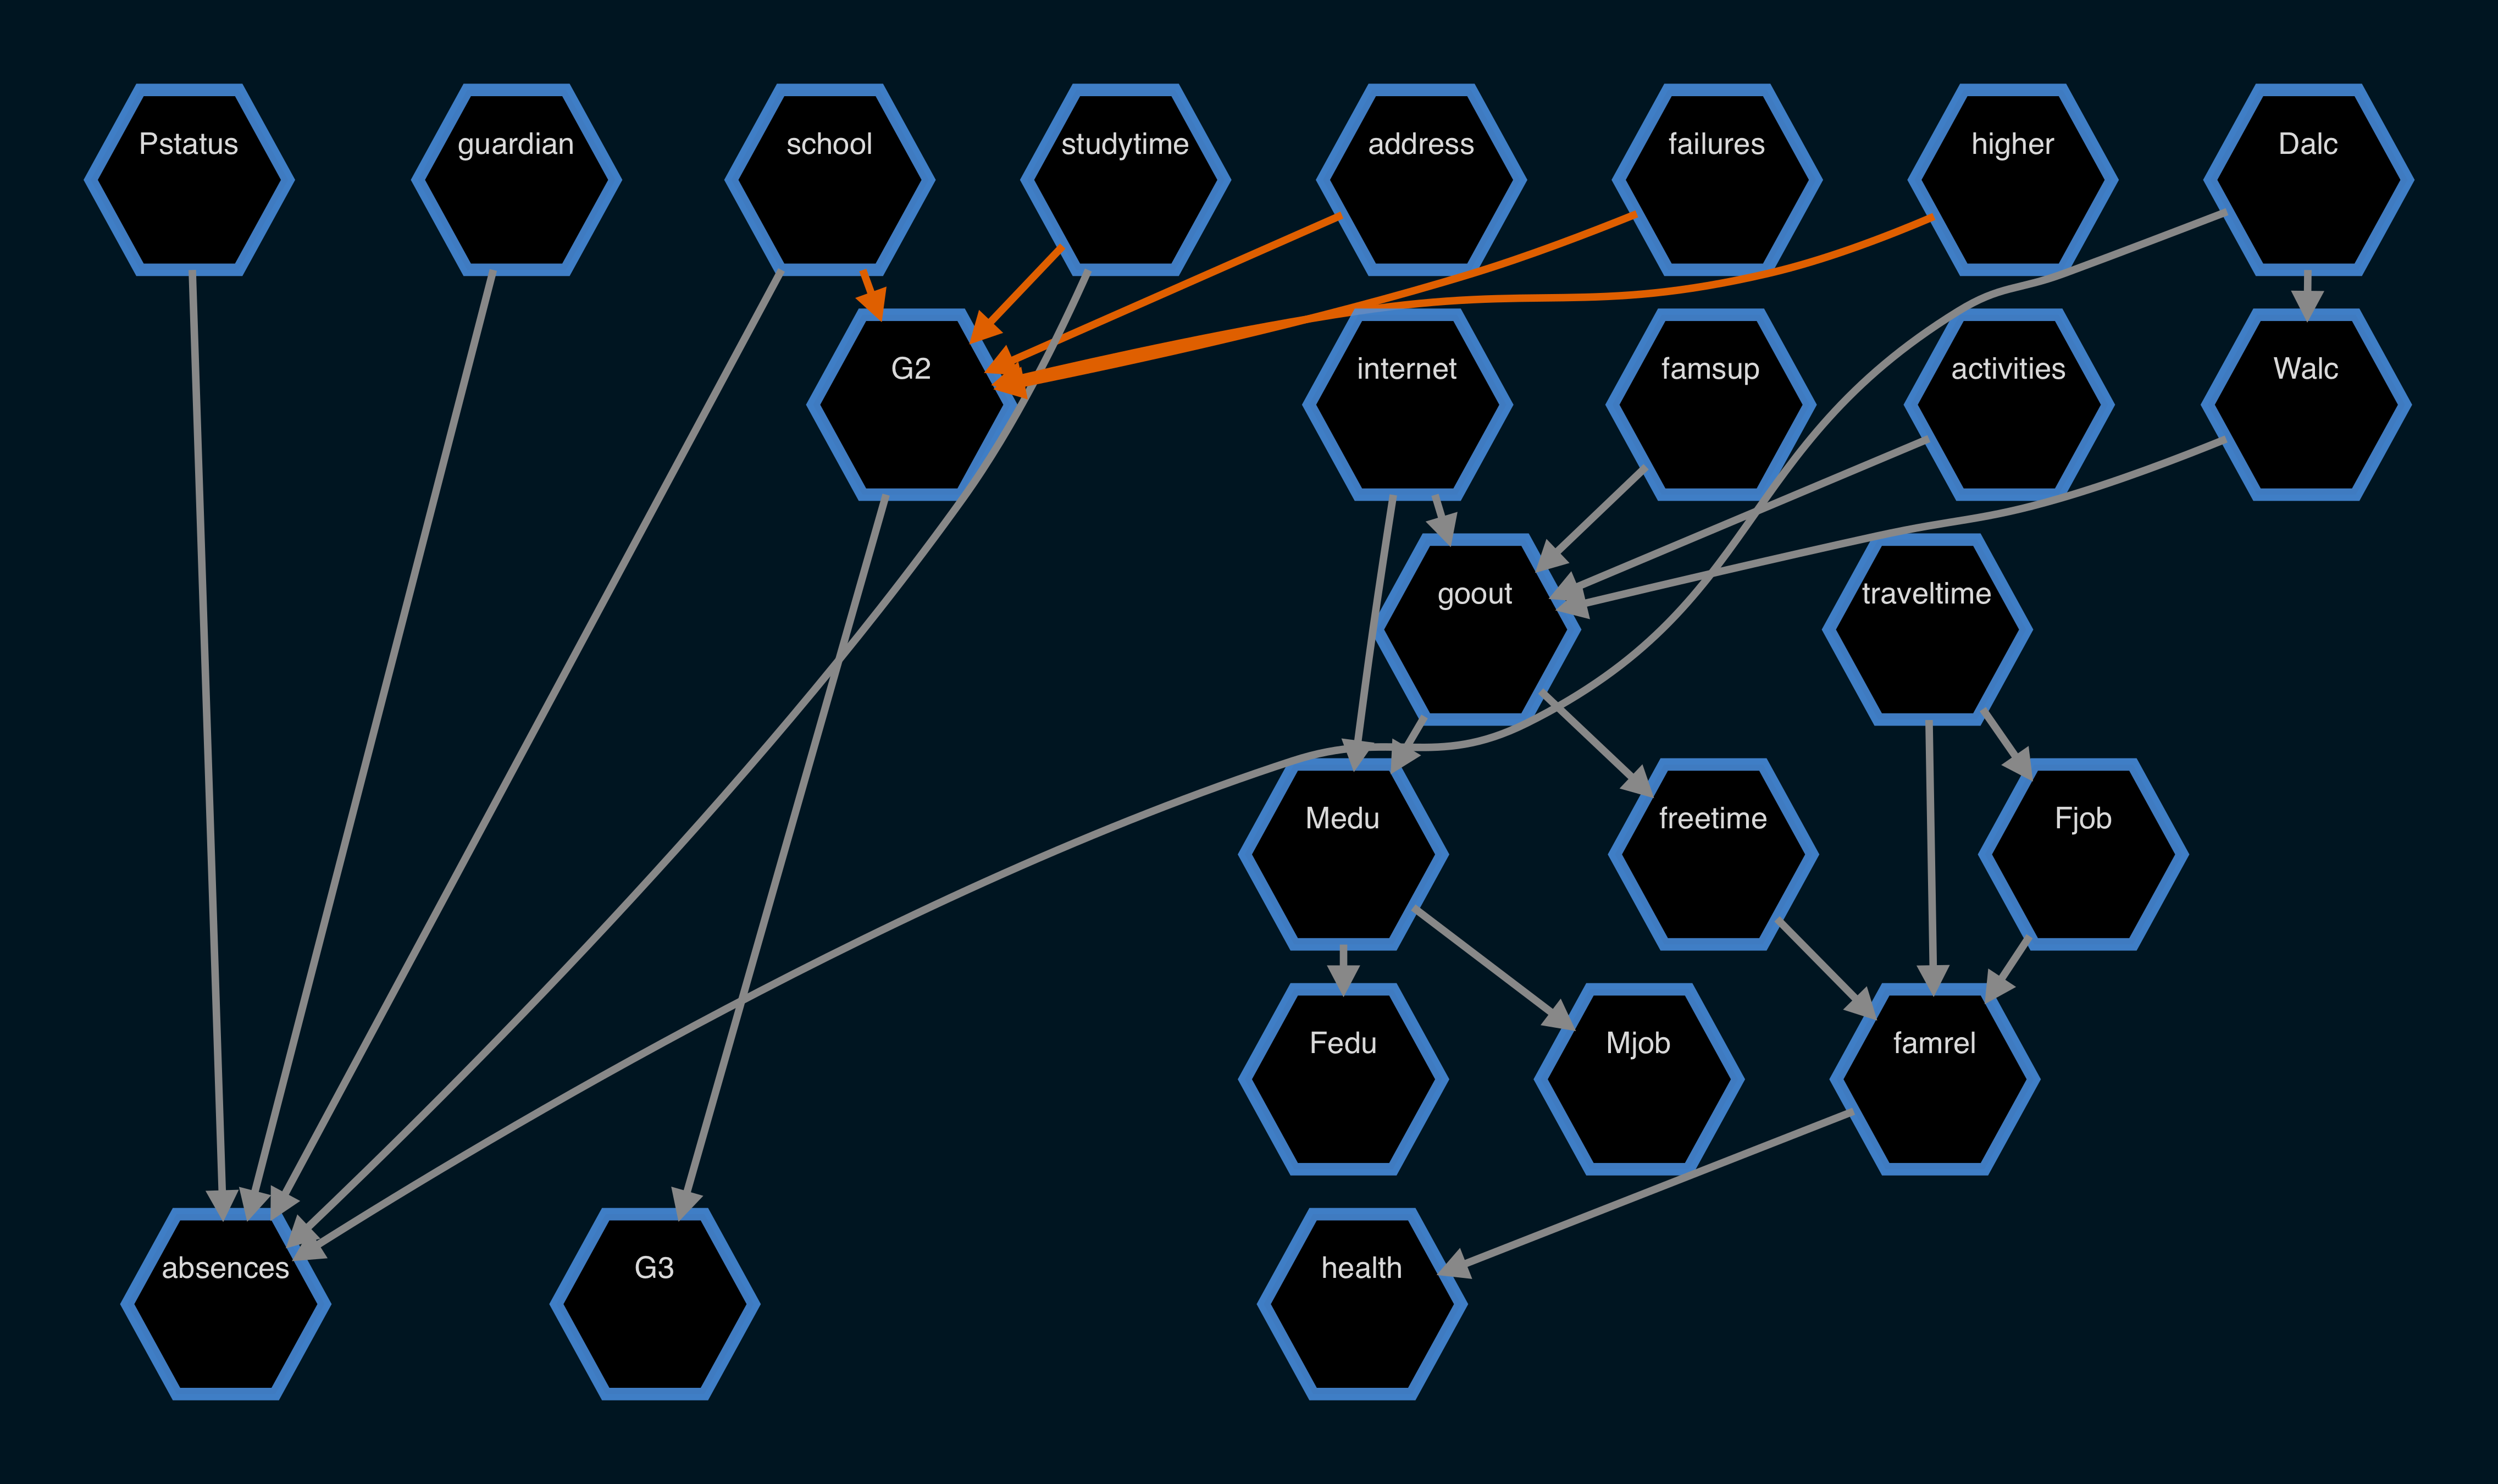

In [6]:
from causalnex.plots import plot_structure
from IPython.display import Image

sm, g1_edges_to_add, g1_edges_to_remove = load_structure_model_and_remove_variable(
    "./supporting_files/student.dot", 
    "G1",
)
viz = plot_pretty_structure(sm, edges_to_highlight=g1_edges_to_remove)
Image(viz.draw(format='png'))

### Building a network with no LV and train it on complete data

Below we learn the network CPDs for the structure model without `G1`.

In [7]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

# Dropping `VehicleYear` because the `fit_node_states` does not accept missing values
bn.fit_node_states_and_cpds(df.drop(['G1'], axis=1))

### Identifying an LV and how it interacts with the model

We need to carefully identify what dependencies this variable would have in the system.
In our case, we are going to add the following edges, and remove other edges that where replacing the LV (rephrase)

In [8]:
print("We are going to add:")
print(g1_edges_to_add)
print("\nWe are going to remove:")
print(g1_edges_to_remove)

We are going to add:
[('school', 'G1'), ('G1', 'G2'), ('address', 'G1'), ('studytime', 'G1'), ('failures', 'G1'), ('higher', 'G1')]

We are going to remove:
[('school', 'G2'), ('address', 'G2'), ('studytime', 'G2'), ('failures', 'G2'), ('higher', 'G2')]


### Adding the LV to the network

In [9]:
bn.add_node(
    node="G1",
    edges_to_add=g1_edges_to_add,
    edges_to_remove=g1_edges_to_remove,
)

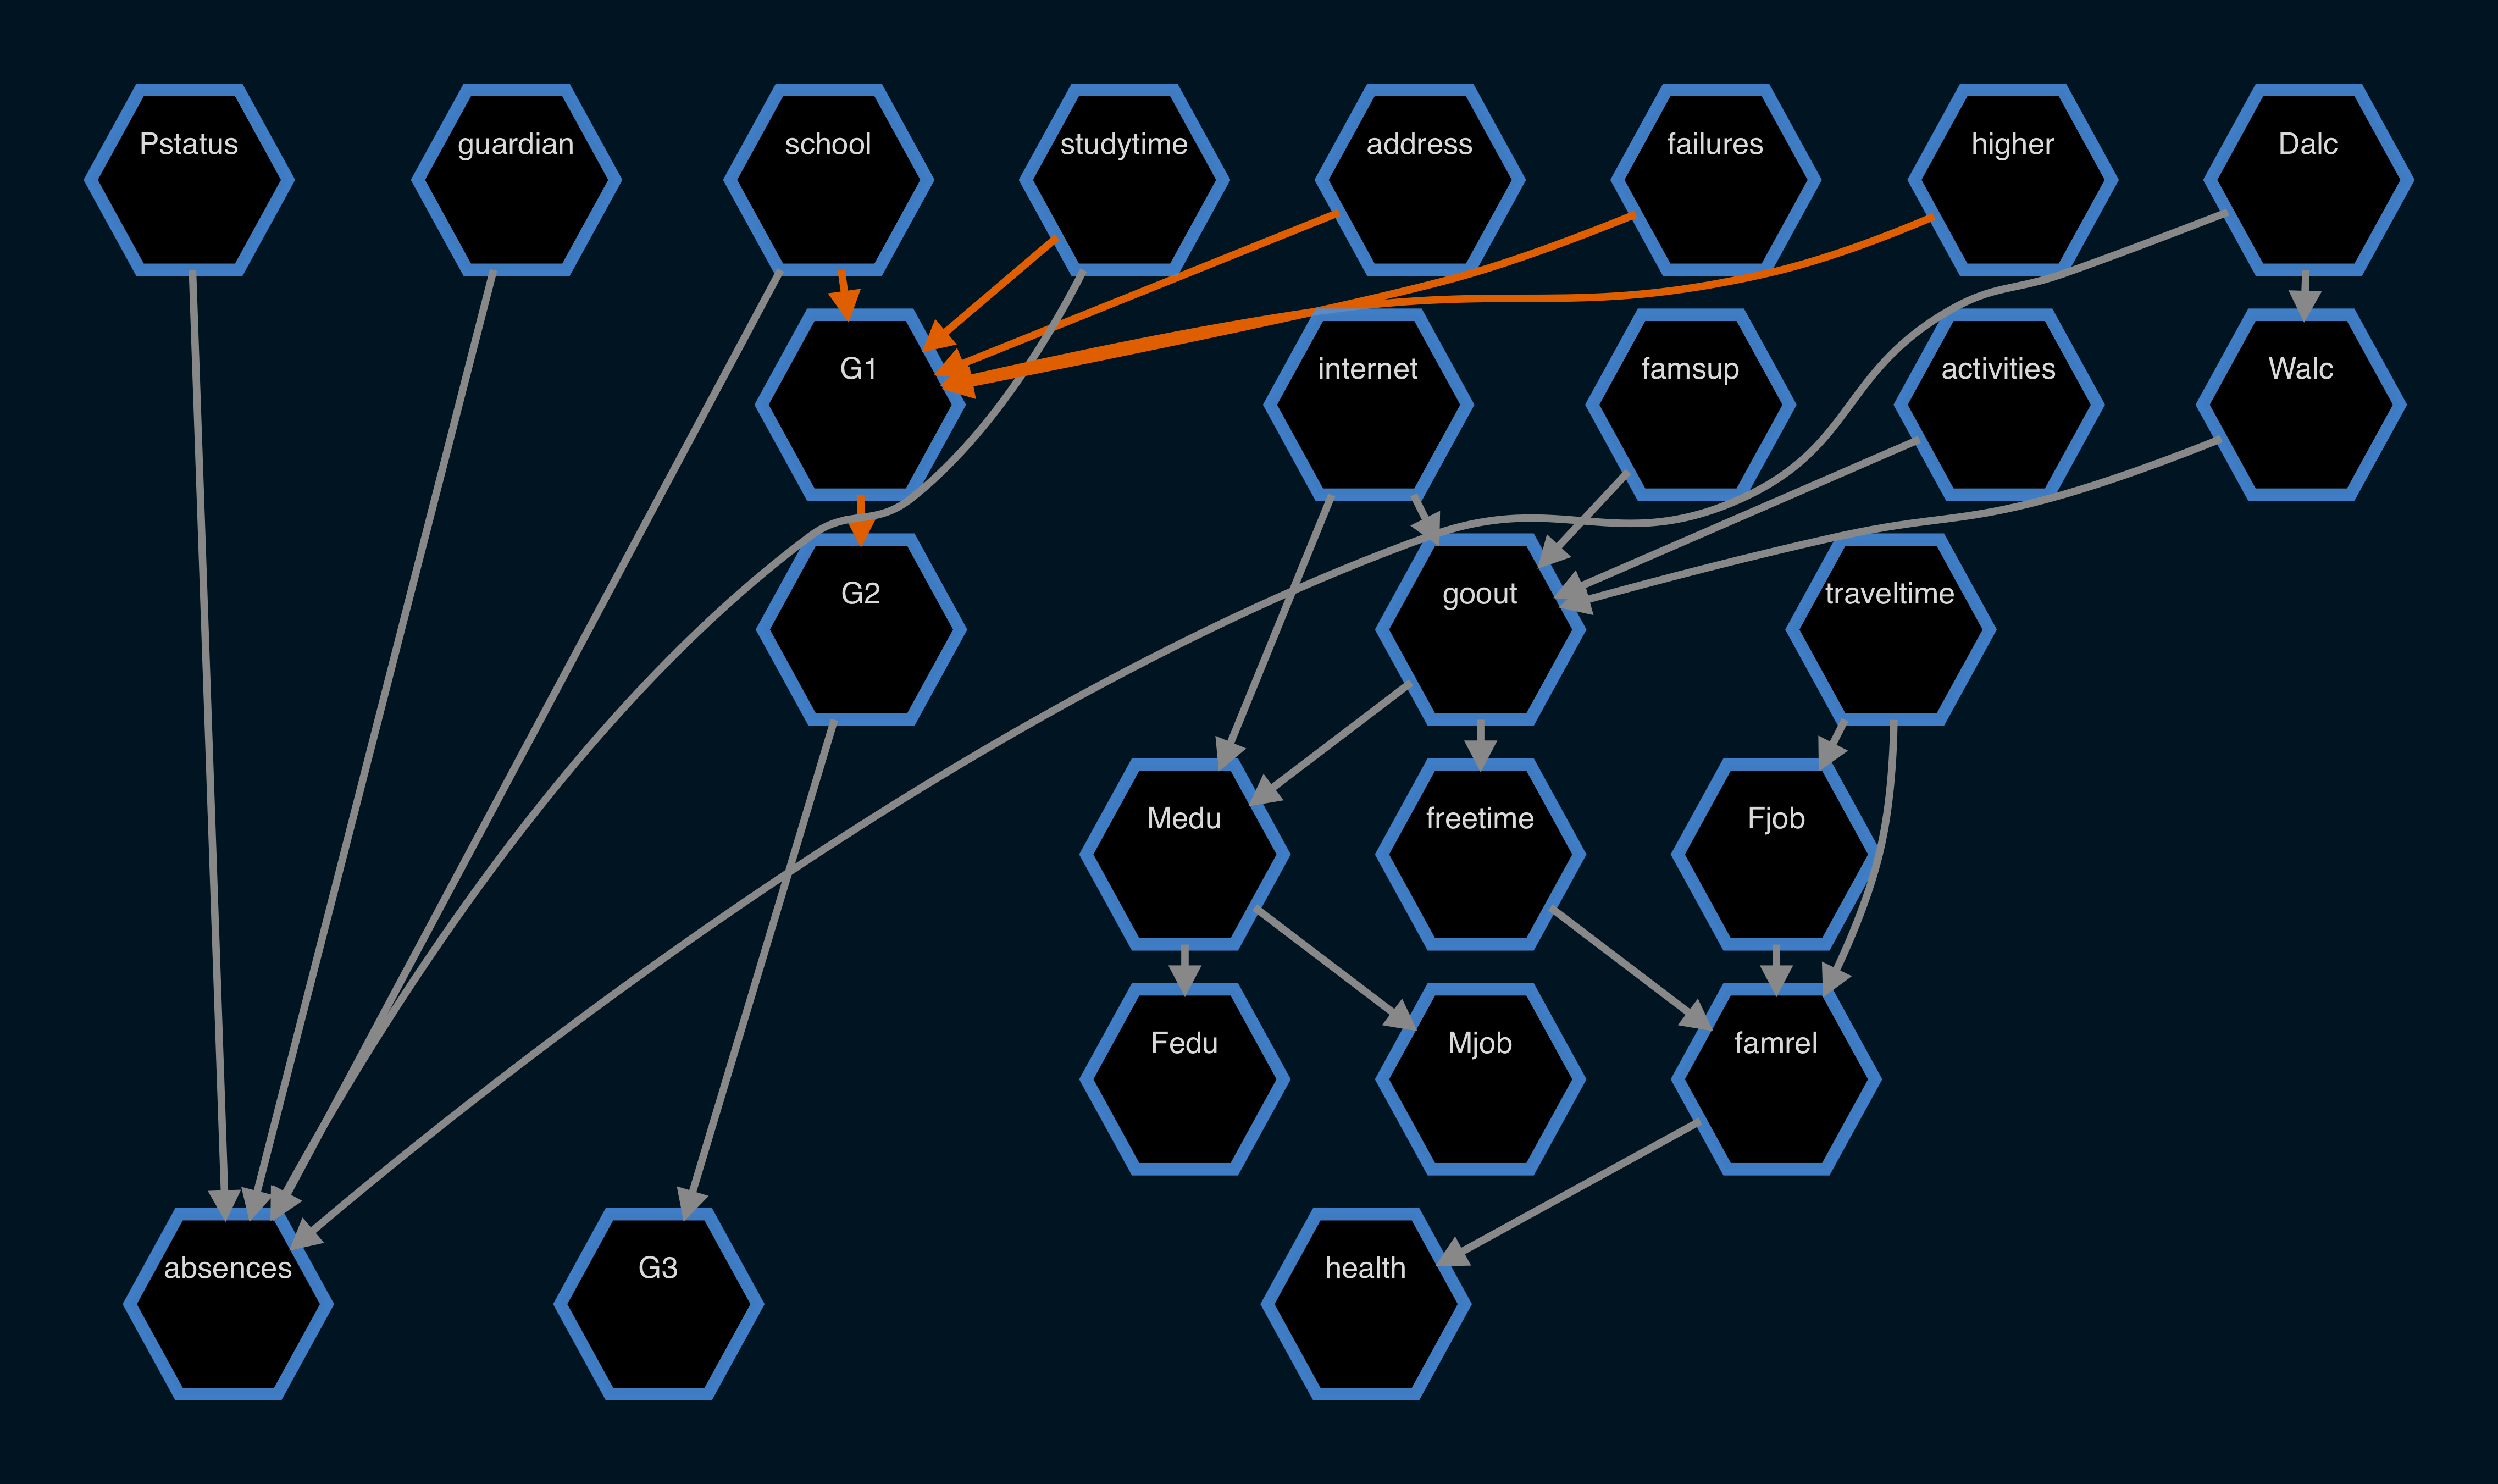

In [10]:
viz = plot_pretty_structure(bn.structure, edges_to_highlight=g1_edges_to_add)
Image(viz.draw(format='png'))

### Establishing constraints to the parameters related to the LV

As explained [here](./05_latent_variable_tutorial.html#Constraints#Constraints), our implementation supports a few types of constraints, and it is very important to provide these constraints. Below we exemplify how to provide `box_constraints` and `priors`.

We propose constraints to the distribution $P(G2|G1)$ based on the assumption that grades in two successive exams are similar. In general, we need to provide constraints to the LV's [CPD](./05_latent_variable_tutorial.html#Definitions)
(In this case $P(G1|Parents(G1)$) and to each of its children CPDs ((In this case $P(G2|Parents(G2)$))

#### Box constraints

The default box constraints are the interval (0, 1) for each parameter. We can shorten this interval by overriding the default box constraints.

This means that each parameter learned will be within the range stablished.

In [11]:
import dataframe_image
import os

def display_colored_df(df: pd.DataFrame):
    """
    Helper function to display pandas dataframe in heatmap style
    """
    
    if not isinstance(df.columns, pd.MultiIndex) or len(df.columns.names) != 1:
        display_df_as_img(df.style.background_gradient(axis=None))
    else:
        df = df.copy()
        df.columns = df.columns.levels[0]        
        temp_file_name = './temp.png'
        
        dataframe_image.export(
            df.style.background_gradient(axis=None), 
            temp_file_name,
        )
        with open(temp_file_name, 'rb') as file:
            display(Image(file.read()))
        
        os.remove(temp_file_name)

We need to provide min/max boundaries for the LV's CPD and the LV's children CPDs. In this case:
dict_keys(['G2', 'G1'])

The default boundaries for every parameter is (0,1), and we should override as many of these values as we can:

Overriding maximum:


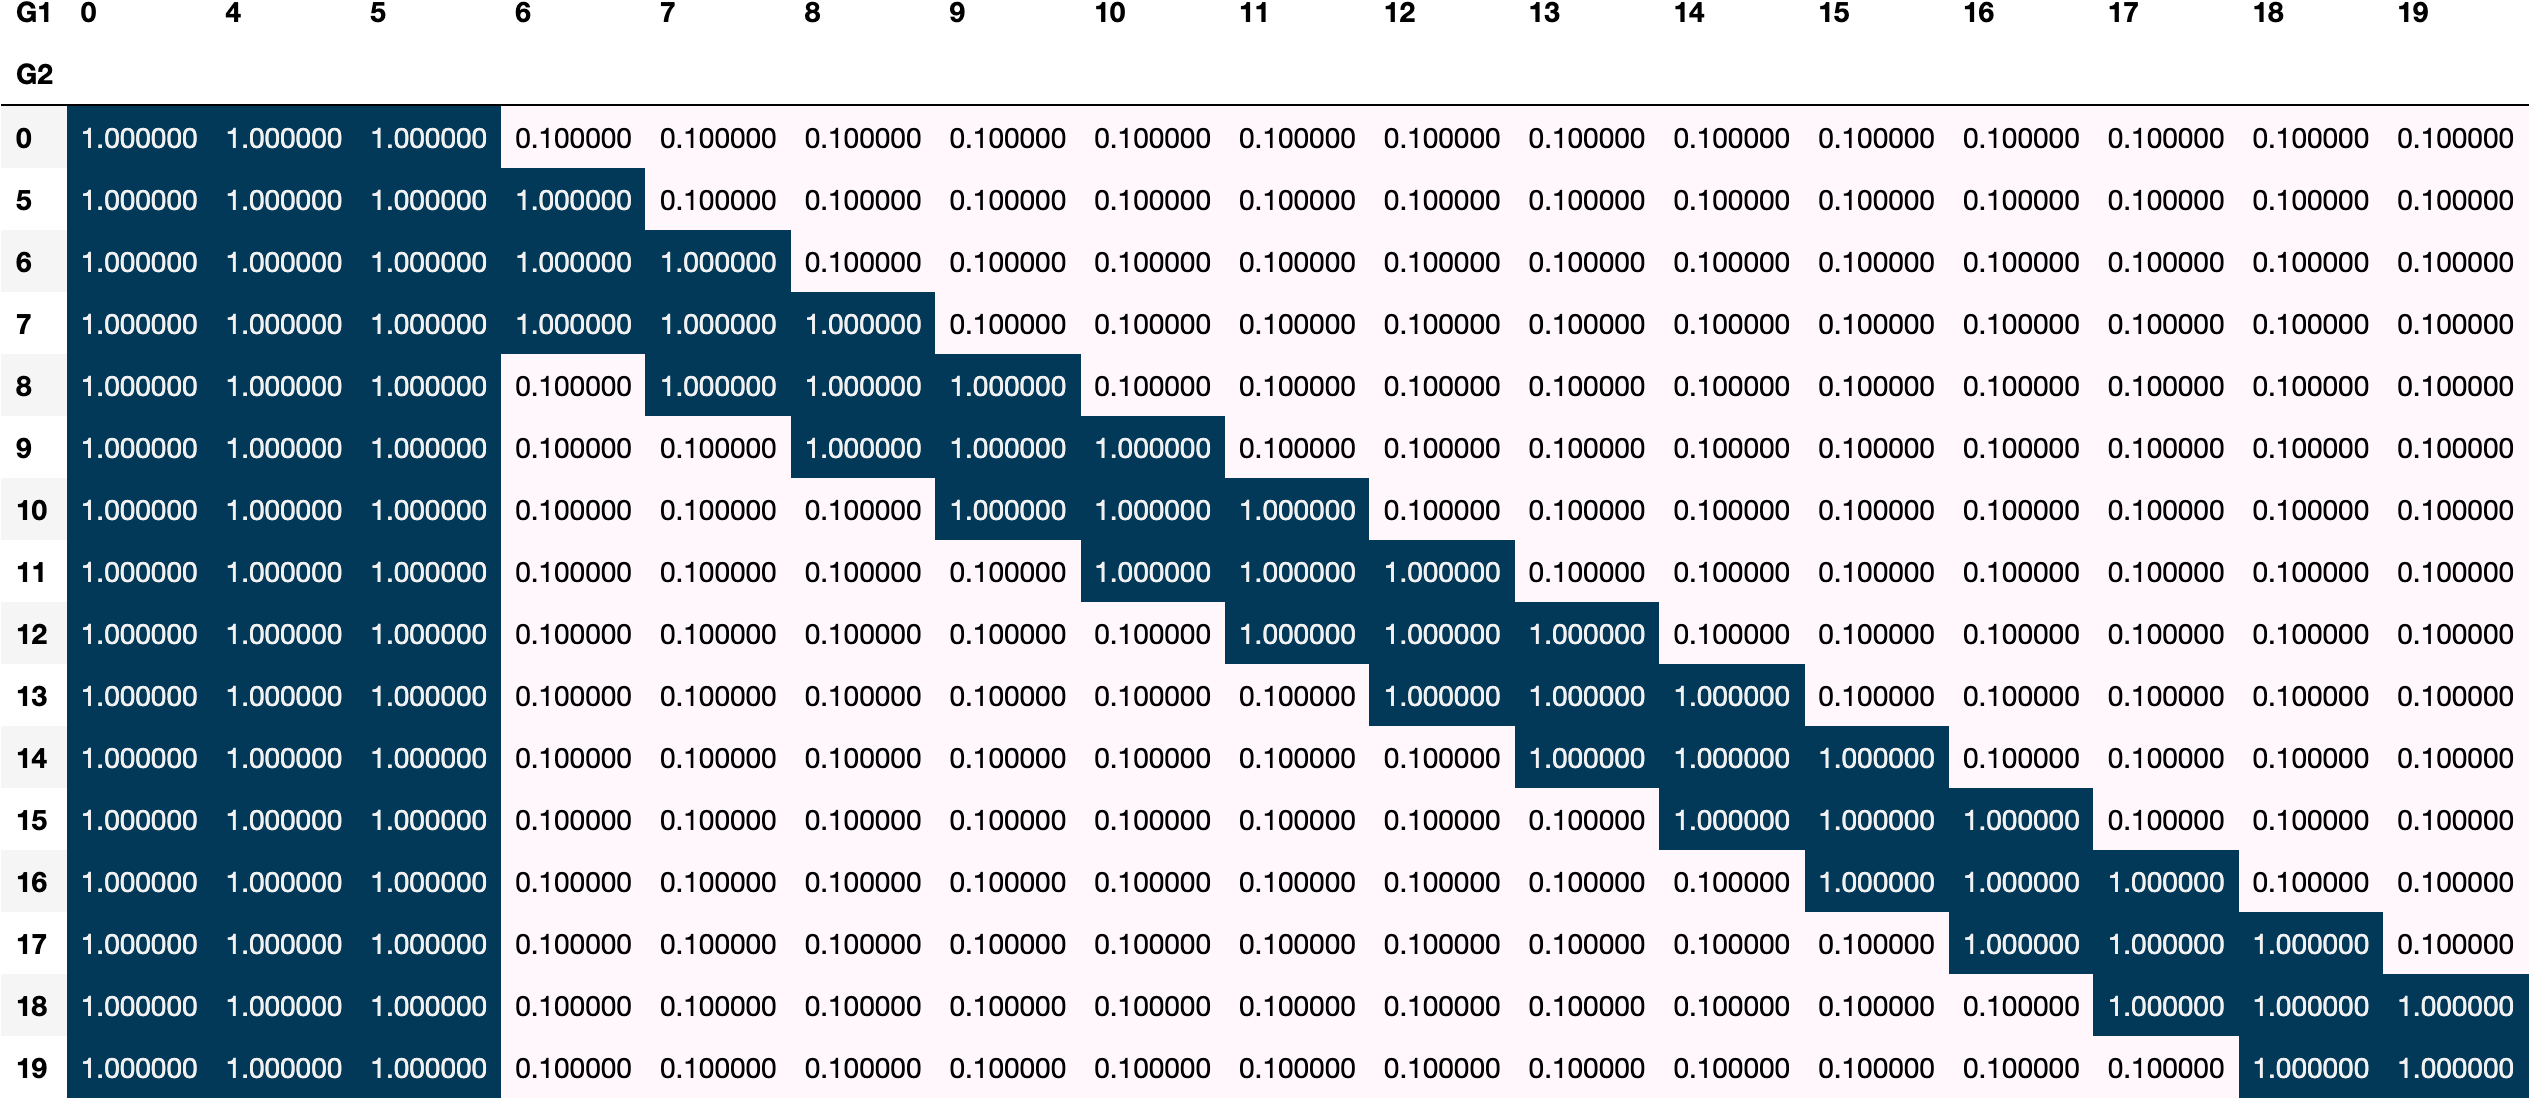

In [12]:
from causalnex.estimator.em import EMSingleLatentVariable

# This returns the default box constraints as a dictionary of pd.Dataframes
# We alter this dictionary to provide custom boundaries
boundaries = EMSingleLatentVariable.get_default_box(
    sm=bn.structure,
    node_states={
        **bn.node_states,
        'G1': {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    },
    lv_name='G1'
)
print("We need to provide min/max boundaries for the LV's CPD and the LV's children CPDs. In this case:")
print(boundaries.keys())

print("\nThe default boundaries for every parameter is "
      "(0,1), and we should override as many of these values as we can:")
print("\nOverriding maximum:")

for i in range(6, 20):
    boundaries['G2'][1].loc[:i -2 ,i] = .1 # proba of G2 << G1 is at most 10% 
    boundaries['G2'][1].loc[i +2: ,i] = .1 # proba of G2 >> G1 is at most 10% 

display_colored_df(boundaries['G2'][1].round(2))

#### Priors

We can provide priors to the CPDs. We should provide priors to the LV's CPD and the LV's children CPDs.

It is sufficient to provide any positive number to each CPD entry. We can interpret the Dirichlet priors in the following manner:

- Each value in a column, normalised by the sum of the values in that column, represents the parameter we believe to be the right one.
- The sum of values in the same column represents the strength of that belief: the higher that sum, the more your initial belief will be incorporated in the final parameters. 
- If we do not have a priori estimation, we can use the value zero for the whole column.

Below we provide an example of specifying priors for $P(G2|G1)$. 

> Note that we did not provide any prior for $G1 \in \{0, 4, 5\}$, which means that the "strength of our belief is zero" for these values of $G1$.

> Also note that we do not need to be right on all of these beliefs: the algorithm will incorporate them along with data to learn the best parameters.

We provide default prior for the LV CPD and its children's
dict_keys(['G2', 'G1'])
The default Priors are 0, and we can override these values


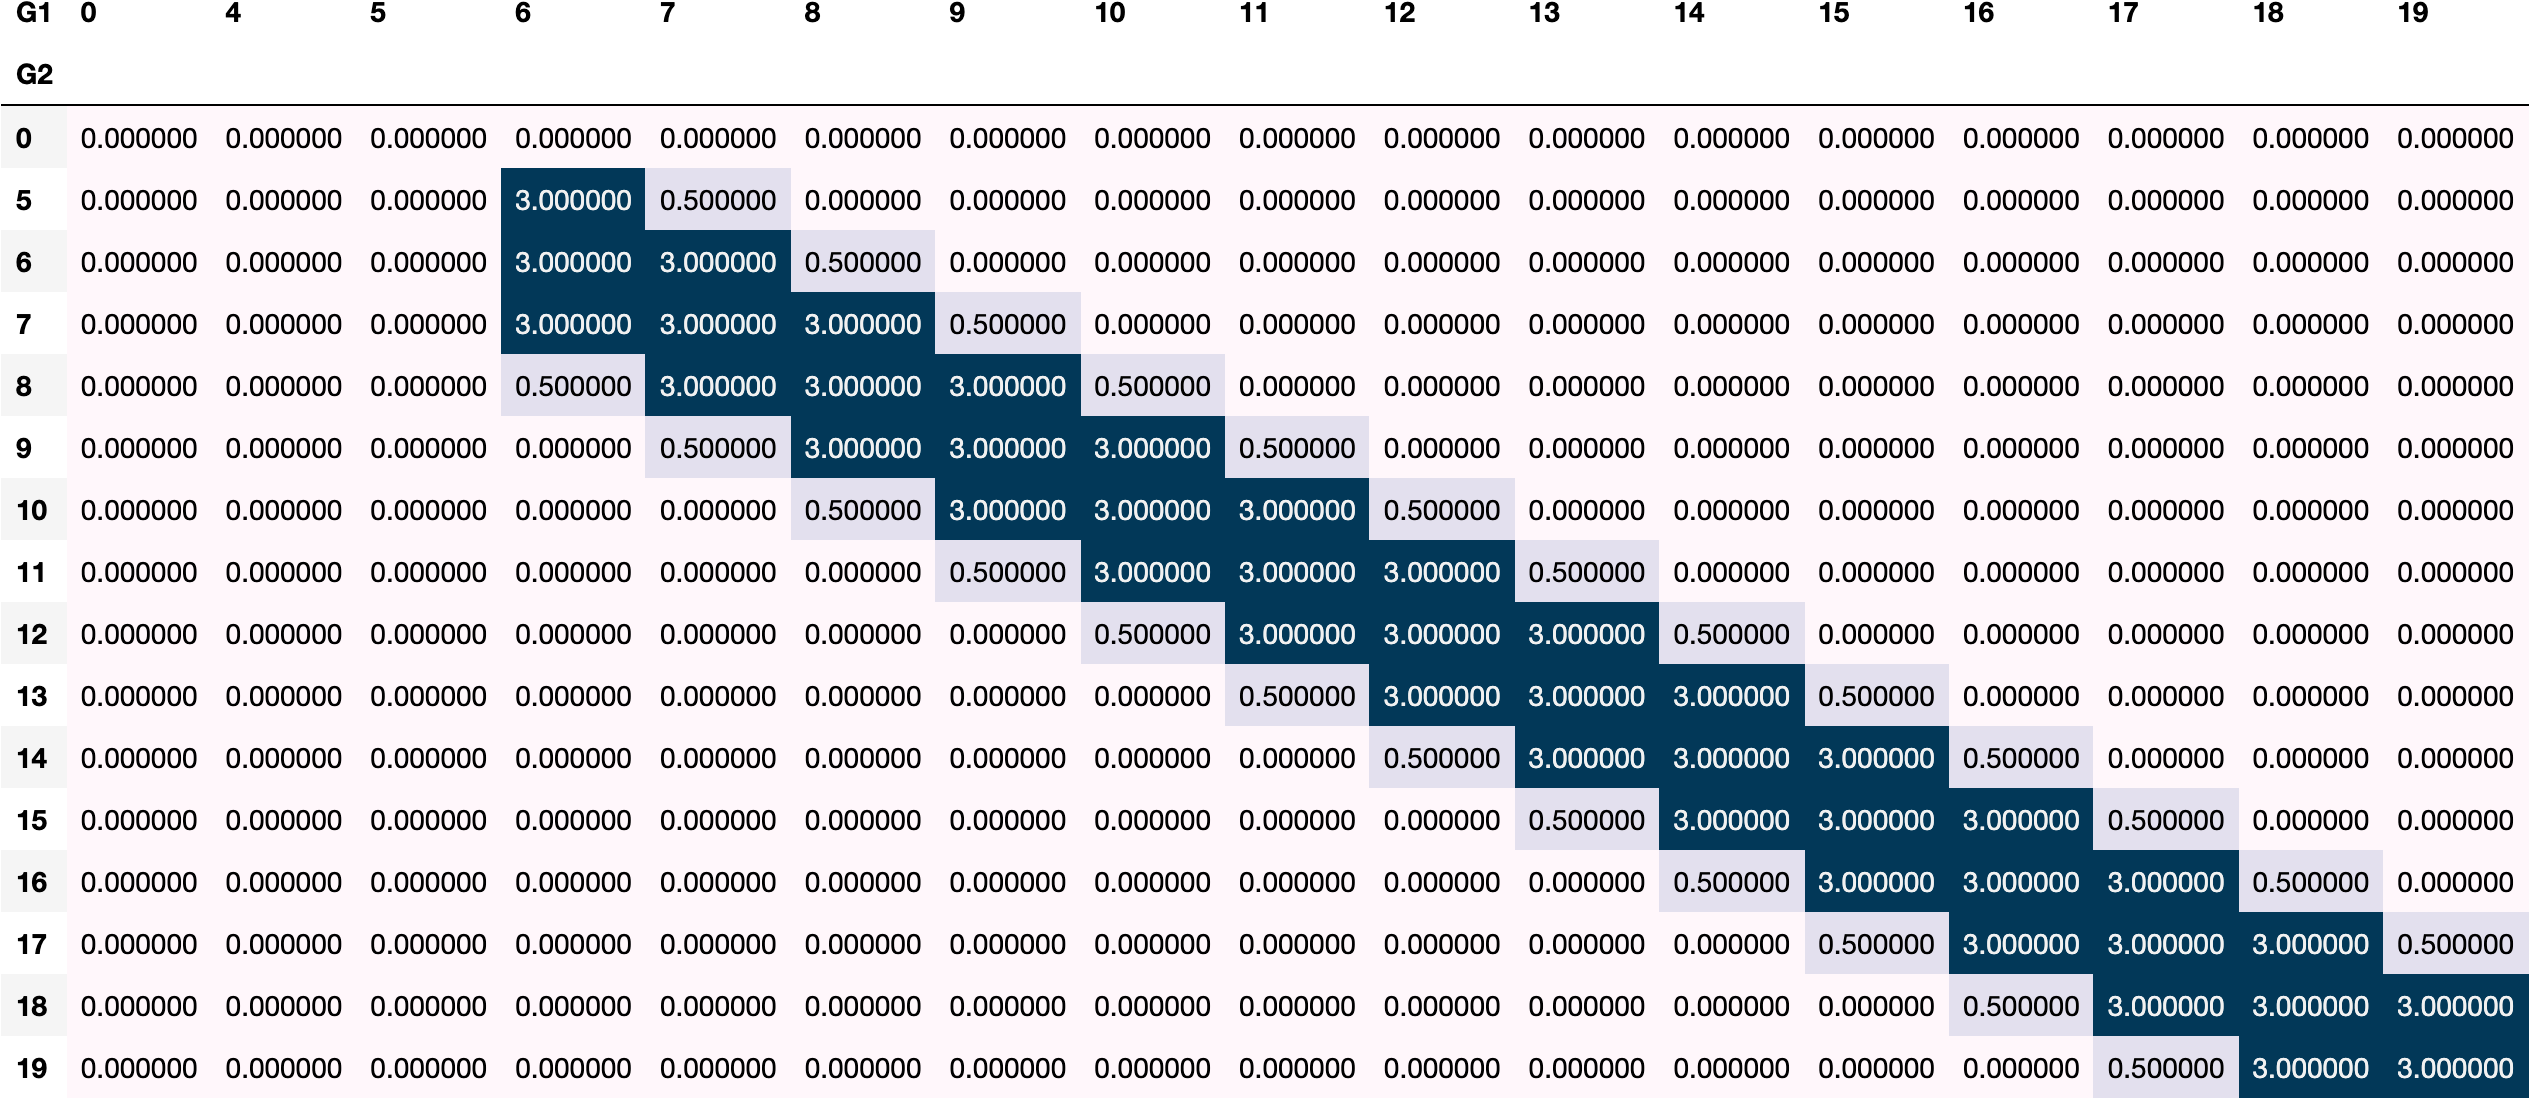

In [13]:
priors = EMSingleLatentVariable.get_default_priors(
    sm=bn.structure,
    node_states={
        **bn.node_states,
        'G1': {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    },
    lv_name='G1',
)
print("We provide default prior for the LV CPD and its children's")
print(priors.keys())

print("The default Priors are 0, and we can override these values")

strength = 10

for i in range(6, 20):
    priors['G2'].loc[i-2:i-1 ,i] = .05 * strength  # probability X strength
    priors['G2'].loc[i+1:i+2 ,i] = .05 * strength  # probability X strength
    priors['G2'].loc[i-1:i +1 ,i] = .3 * strength  # probability X strength

display_colored_df(priors['G2'])

### Fitting the parameters of the LV and its children 

Note that the only a small number of parameters need to be learned (see [this](#property-em) property): the LV's and its children CPDs.

In [14]:
# This takes several minutes...
bn.fit_latent_cpds(
    lv_name="G1",
    lv_states=[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    data=df,
    box_constraints=boundaries,
    priors=priors,
    n_runs=30,
)

We can, now, use the trained BN. Below I create a simple query from CausalNex's inference engine.

In [15]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
ie.do_intervention('studytime', 3)
query = ie.query()

print("P(G1=10|do(studytime=3)) = ", query["G1"][10])
print("P(G2=10|do(studytime=3)) = ", query["G2"][10])

P(G1=10|do(studytime=3)) =  0.005380615673278853
P(G2=10|do(studytime=3)) =  0.09461209113528016


#### Checking the accuracy of the parameters learnt

Since the missing data was introduced rather than being there a priori, we can simply complete the missing data, fit the parameters with MLE, and compare the CPDs learnt by the two methods.

We can see that, if we average the absolute error in every single parameter, the average error is of 0.05, which means that:

> The parameters learnt in an almost unsupervised fashion are very close to the ones learnt with the full dataset.

In [16]:
bn_check = BayesianNetwork(bn.structure)
df_complete = df.copy(deep=True)
df_complete["G1"] = g1_column

bn_check.fit_node_states_and_cpds(df_complete)
vals = np.concatenate(
    tuple(
        np.abs(bn.cpds[el] - bn_check.cpds[el]).values.flatten() 
        for el in ['G1','G2']
    )
)
print(vals.mean())

0.04937839763873895


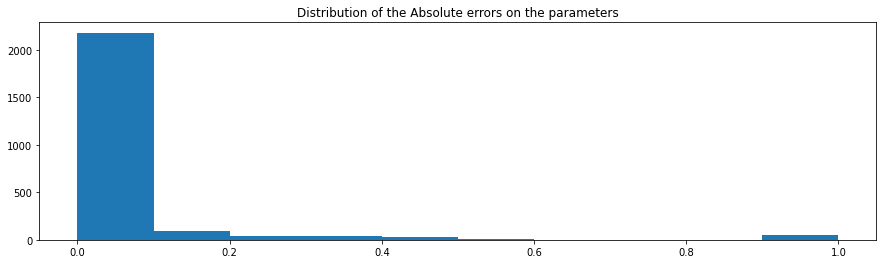

In [17]:
import matplotlib as mpl

plt.figure(figsize=(15, 4))
plt.title('Distribution of the Absolute errors on the parameters')
plt.hist(vals)
plt.show()

## Case study 2: Car insurance dataset

This case study involves a car insurance model and uses a well-known synthetic dataset proposed in [[1]](./05_latent_variable_tutorial.html#References). We assume that we do have access to a SMALL amount of data for a variable and use EM to add this variable to the model.

The structure of this network was first introduced in [[1]](./05_latent_variable_tutorial.html#References) and the dataset is generated synthetically, as per the original source. We notice one variable, `VehicleYear`, about which we have almost no data (50 samples provided which means 99.5% of data missing).

> In reality, because the data is simulated, we have access to the data which would be missing in the project. This is on the variable `vehicle_column`

dataset rows and columns:  (10000, 24)
Non missing "VehicleYear":  50


Age  Mileage  Cushioning  SocioEcon  GoodStudent  RiskAversion  OtherCar  \
0    1        1           1          1            0             1         1   
1    1        1           1          0            2             2         1   
2    0        1           0          2            2             2         2   
3    2        0           1          1            2             0         0   
4    2        1           0          2            1             2         1   

   VehicleYear  MakeModel  SeniorTrain  HomeBase  AntiTheft  RuggedAuto  \
0          NaN          1            2         0          1           2   
1          NaN          0            1         2          1           1   
2          NaN          0            1         2          1           2   
3          NaN          1            1         1          0           2   
4          NaN          2            1         2          0           1   

   Antilock  CarValue  DrivingSkill  Theft  DrivQuality  Accident  ThisCarDam  \
0         1         0             0      1            1         2           0   
1         0         1             1      1            0         2           0   
2         0         1             1      1            2         1           0   
3         0         2             2      2            0         1           2   
4         2         2             1      0            2         2           1   

   OtherCarCost  MedCost  ThisCarCost  PropCost  
0             1        2            2         1  
1             0        2            2         1  
2             2        0            0         1  
3             1        2            1         1  
4             1        1            1         1

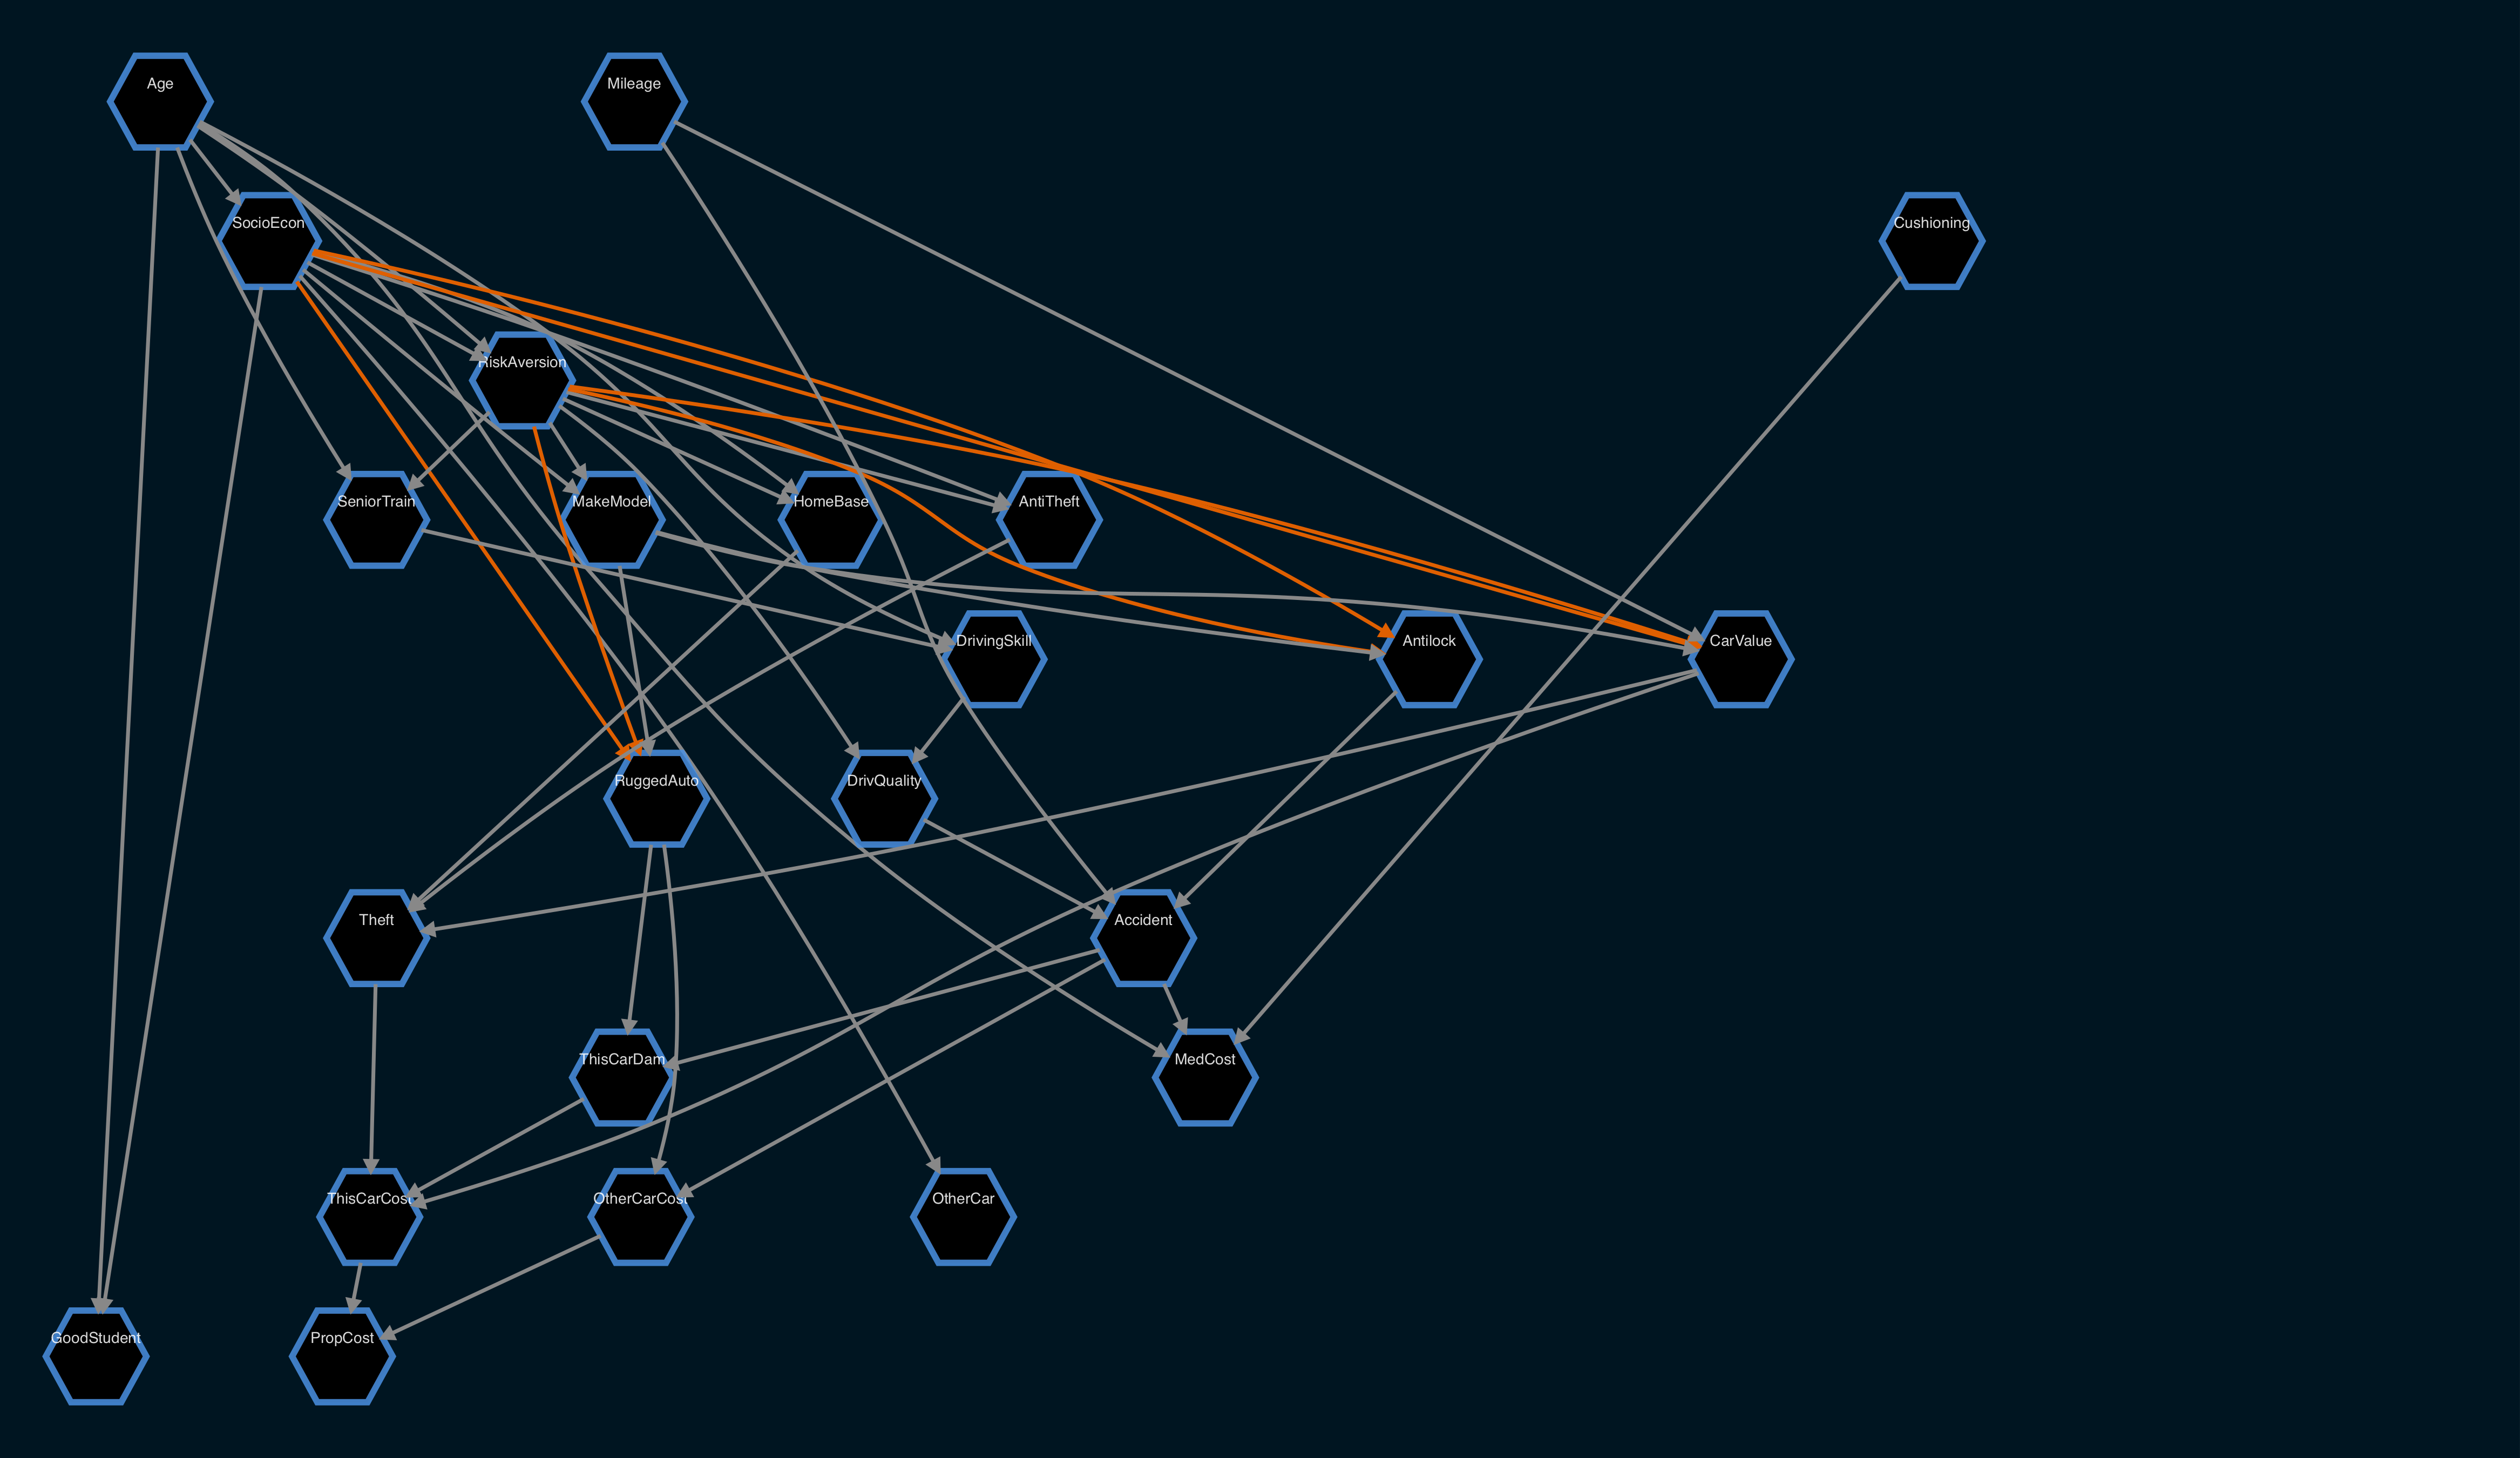

In [18]:
df = pd.read_csv('./supporting_files/insurance.csv')
vehicle_column = df["VehicleYear"]

# Mock incomplete data with only a handful of known samples
np.random.seed(42)
rows_nan = np.random.choice(len(df), size=len(df) - 50, replace=False)
df.loc[rows_nan, "VehicleYear"] = np.nan

print("dataset rows and columns: ", df.shape)
print('Non missing "VehicleYear": ', sum(~df["VehicleYear"].isna()))
display(df.head())

sm, vehicle_edges_to_add, vehicle_edges_to_remove = load_structure_model_and_remove_variable(
    "./supporting_files/insurance.dot",
    "VehicleYear",
)
viz = plot_pretty_structure(sm, edges_to_highlight=vehicle_edges_to_remove)
Image(viz.draw(format='png'))

### Building a network with no LV and train it on complete data

Below we learn the network CPDs for the structure model without `VehicleYear`.

In [19]:
bn = BayesianNetwork(sm)

# Dropping `VehicleYear` because the `fit_node_states` does not accept missing values
bn.fit_node_states_and_cpds(df.drop(['VehicleYear'], axis=1))

### Identifying an LV and adding it to the network

We are going to add:
[('SocioEcon', 'VehicleYear'), ('RiskAversion', 'VehicleYear'), ('VehicleYear', 'RuggedAuto'), ('VehicleYear', 'Antilock'), ('VehicleYear', 'CarValue')]

We are going to remove:
[('SocioEcon', 'RuggedAuto'), ('SocioEcon', 'Antilock'), ('SocioEcon', 'CarValue'), ('RiskAversion', 'RuggedAuto'), ('RiskAversion', 'Antilock'), ('RiskAversion', 'CarValue')]


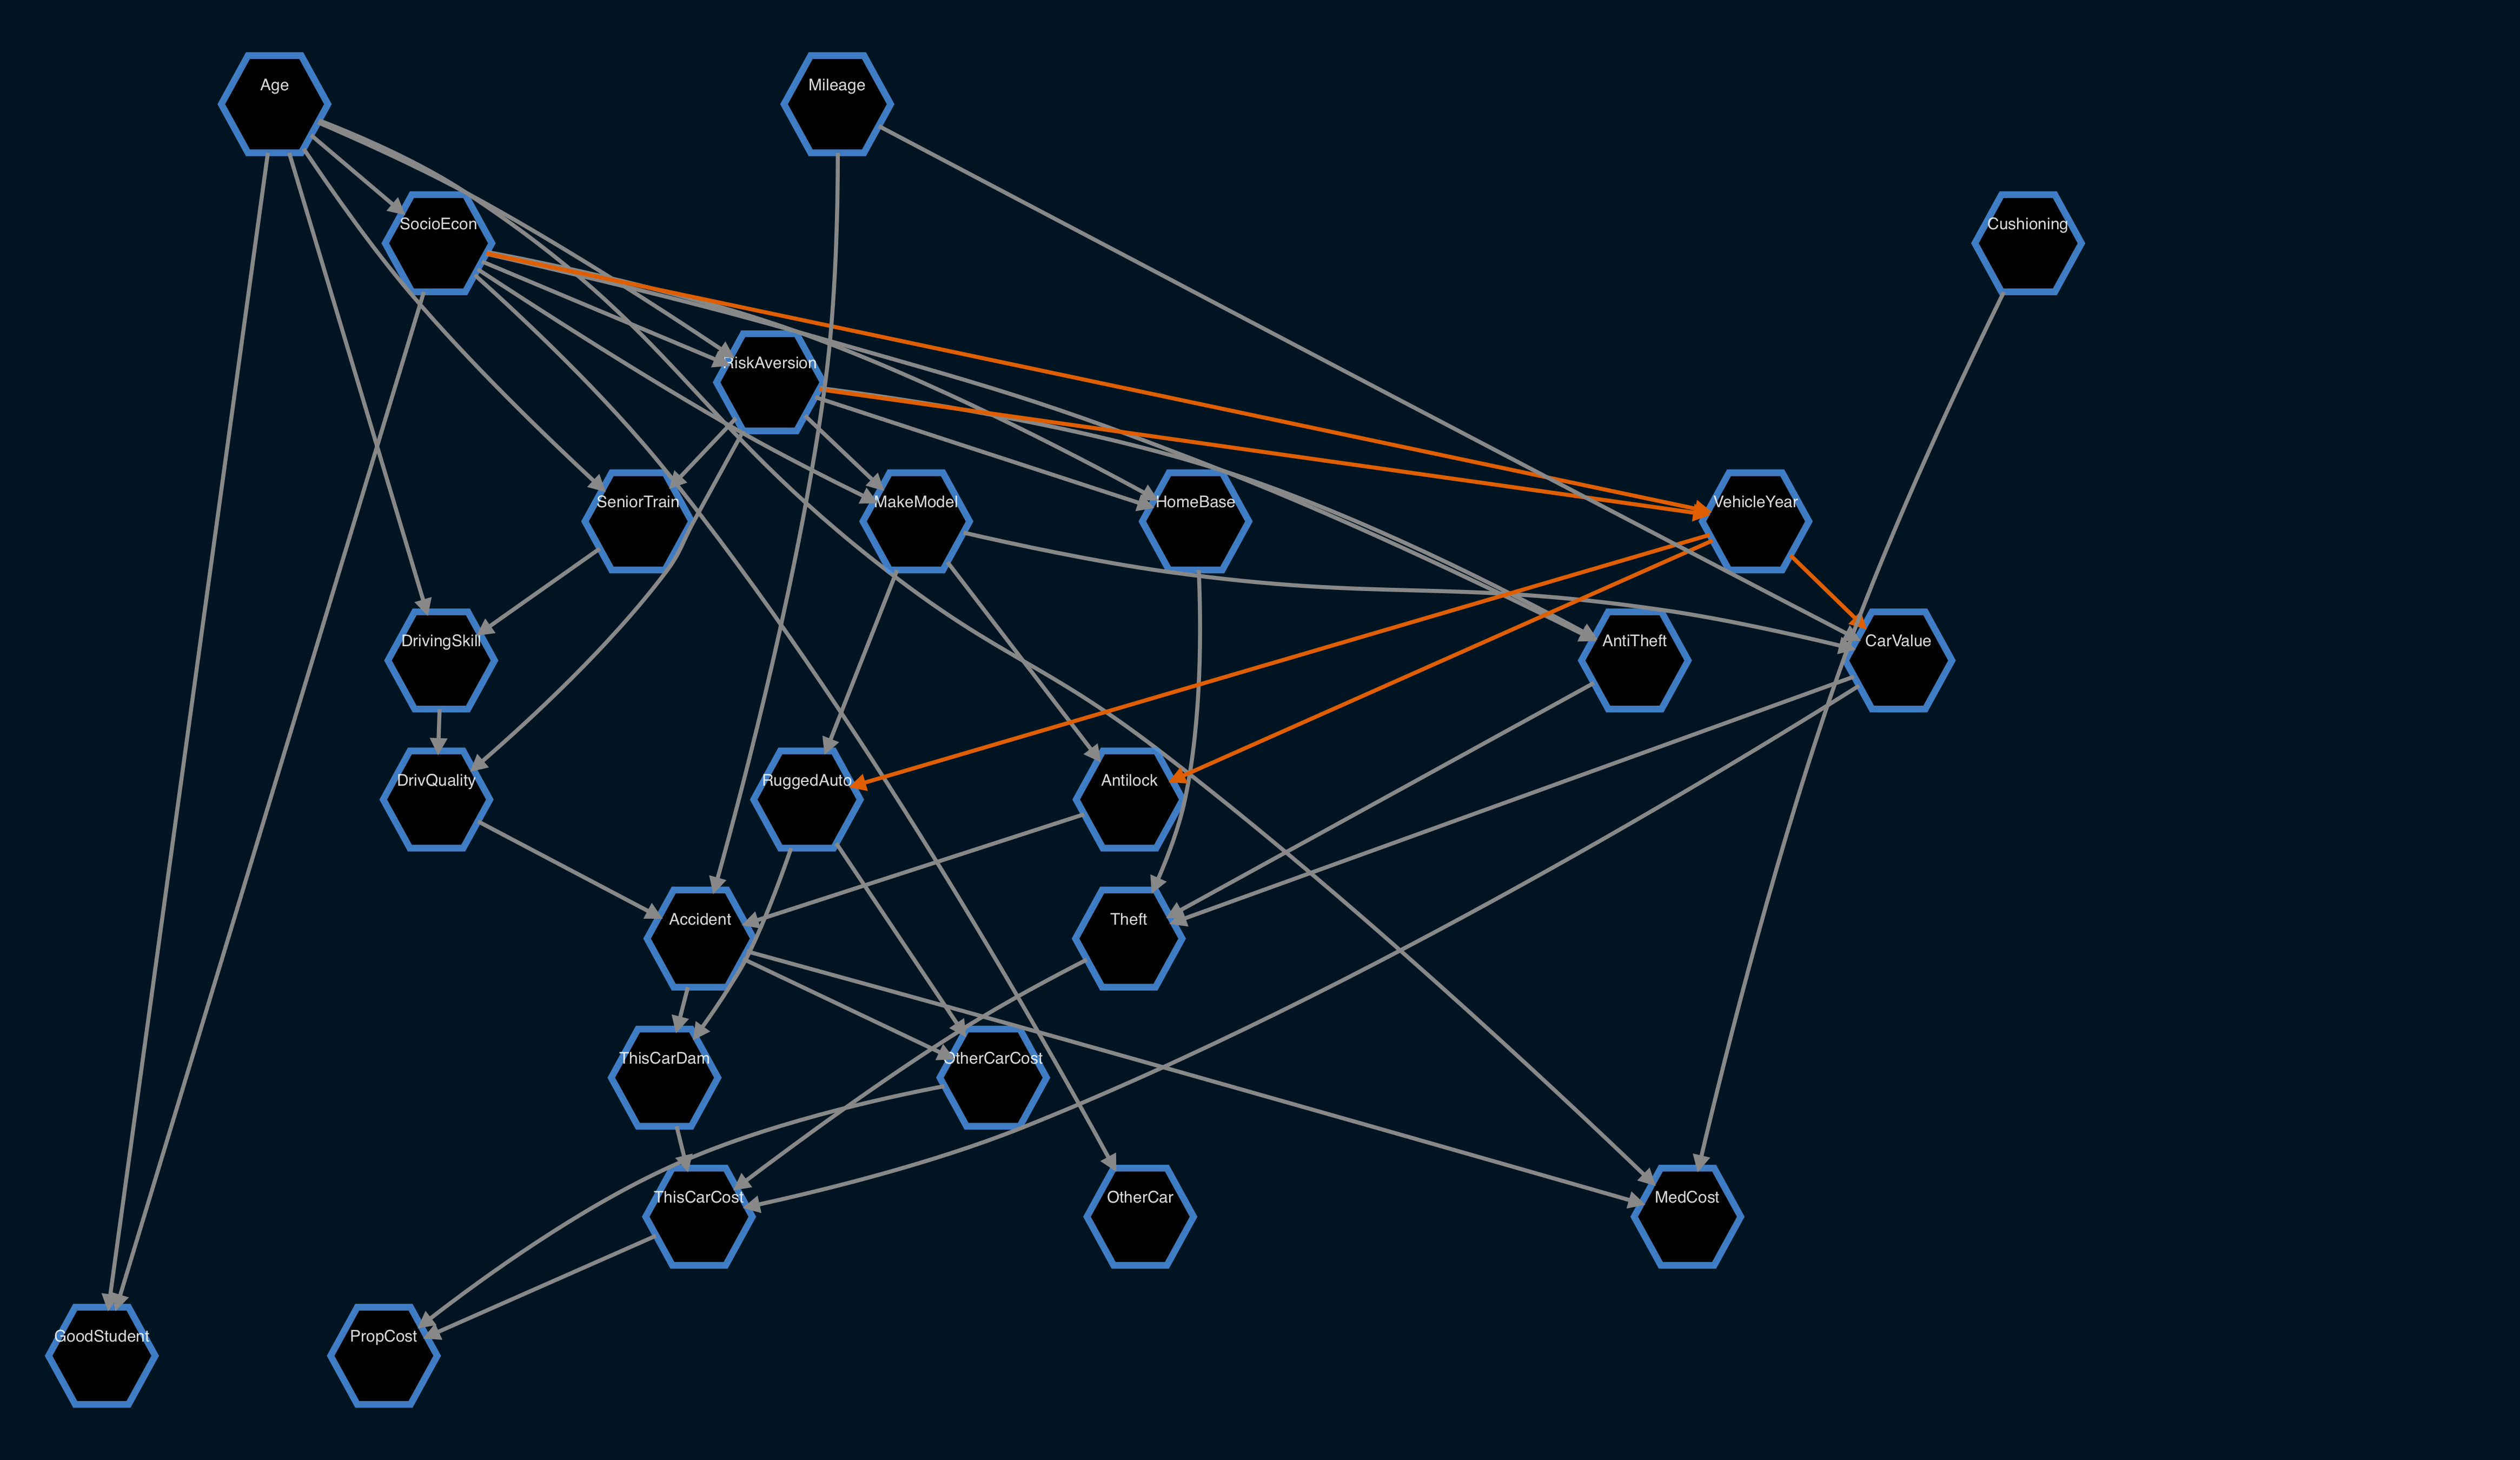

In [20]:
print("We are going to add:")
print(vehicle_edges_to_add)
print("\nWe are going to remove:")
print(vehicle_edges_to_remove)

bn.add_node(
    node="VehicleYear",
    edges_to_add=vehicle_edges_to_add,
    edges_to_remove=vehicle_edges_to_remove,
)
viz = plot_pretty_structure(bn.structure, edges_to_highlight=vehicle_edges_to_add)
Image(viz.draw(format='png'))

### Establishing constraints to the parameters related to the LV

Because we have some amount of data, we skip the addition of constraints at this point.
However, it is advisable to include constraints in general.

### Fitting the parameters of the LV and its children 

Note that the only a small number of parameters need to be learned (see the EM property in the [Appendix](./05_latent_variable_tutorial.html#Appendix)): the LV's and its children CPDs.

In [21]:
# This takes several minutes...
bn.fit_latent_cpds(
    lv_name="VehicleYear",
    lv_states= [0, 1, 2],
    data=df,
    n_runs=20,
    non_missing_data_factor=10,
)

We can now use the trained BN. Below we create a simple query from CausalNex's inference engine.

In [22]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
ie.do_intervention('SocioEcon', 2)
query = ie.query()

print("P(Accident=0|do(SocioEcon=2)) = ", query["Accident"][0])
print("P(VehicleYear=2|do(SocioEcon=2)) = ", query["VehicleYear"][2])

P(Accident=0|do(SocioEcon=2)) =  0.32202245390606243
P(VehicleYear=2|do(SocioEcon=2)) =  0.4484888468338799


#### Checking the accuracy on the parameters learnt

Since the 99.5% missing data was introduced rather than being there a priori, we can simply complete the missing data, fit the parameters with MLE, and compare the CPDs learnt by the two methods.

We can see that, if we average the absolute error in every single parameter, the average error is 0.07, implying that:

> The parameters learnt in an almost unsupervised fashion are very close to the ones learnt with the full dataset.

In [23]:
bn_check = BayesianNetwork(bn.structure)
df_complete = df.copy()
df_complete["VehicleYear"] = vehicle_column

bn_check.fit_node_states_and_cpds(df_complete)
vals = np.concatenate(
    tuple(
        np.abs(bn.cpds[el] - bn_check.cpds[el]).values.flatten() 
        for el in ['Antilock', 'CarValue', 'RuggedAuto', 'VehicleYear']
    )
)
print(vals.mean())

0.07213539176401054


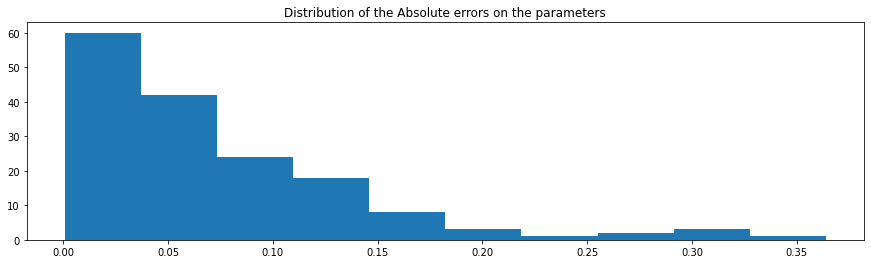

In [24]:
import matplotlib as mpl

plt.figure(figsize=(15, 4))
plt.title('Distribution of the Absolute errors on the parameters')
plt.hist(vals)
plt.show()

## Appendix

### How to choose where to add an LV?

One should always add LV edges based on the known true causality relationship. 

However, certain configurations allow EM to more likely converge to the correct CPD parameters of the LV. Other configurations make it more difficult for EM to learn the correct parameters and may create misleading results.

Understanding these configurations is therefore crucial to adding latent variables to a BN.

### An interesting property of EM for Bayesian networks

Applying EM for Bayesian Networks in our current setting (i.e. no missing data except for the LV itself) has the following property:

> **The only parameters that need to be learned through EM are the  [CPDs](./05_latent_variable_tutorial.html#Definitions) of the LV itself and its children.** The other parameters CPDs can be learned directly using MLE.

This property comes directly from the conditional independences on which the BN is based.

From this property, we can limit ourselves to understanding the behaviour of EM given the LV's [Markov blanket](./05_latent_variable_tutorial.html#Definitions). We detail the different possible situations we can face in the next section.

### What structures allow EM to correctly recover parameters?

In order for EM to learn meaningful parameters, **there has to be some correlation between variables that is not explained by the edges among observed variables**.

Some cases where EM works well are:

1. In the naive Bayes structure below, EM can work well because a possible correlation between the observed variables can only be explained by a causality of the LV ($Z$)

![](supporting_files/naive_bayes.jpg)

2. In the following structure, $Z$ explains the correlations among the nodes on the bottom, and also the correlation between nodes on top and the ones on the bottom. It is likely that we are able to recover the correct parameters in this situation.

![](supporting_files/parent_latent_child.jpg)

Other cases where EM is not likely to provide meaningful parameters:

1. In the cases where the LV has no children, it is not possible to infer its true parameters. EM will still converge but not necessarily to a meaningful result.

![](supporting_files/childless_latent.jpg)

2. As opposed to our Naive Bayes example, below we have a structure whereby the children are fully connected. In this case, even if, in reality, the unobserved variable affects all children, all the correlations could be derived from the existing edges. The edge $e \rightarrow f$ explains the correlation between $a$ and $b$ for example. Therefore, EM would likely not retrieve the correct parameters for $Z$.

![](supporting_files/connected.jpg)


### Definitions

[1] A CPD of a node $X$ is a table specifying the probability $P(X|Parents(X))$. In a discrete Bayesian Network, these are provided as tables. The parameters of a Bayesian Network are the set of the entries in every node of the BN.

[2] A Markov Blanket of a node is defined as the set of its parents, its children and its parent's children


## References

[1] J. Binder, D. Koller, S. Russell, and K. Kanazawa. Adaptive Probabilistic Networks with Hidden Variables. Machine Learning, 29(2-3):213-244, 1997.